In [ ]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/compare_mixed_model/"
CONFIG_PATH = "../config/workspace_config_HLF.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 24})

load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)
with open(CONFIG_PATH, "r") as f:
    data_config = yaml.safe_load(f)

data_config = DataProcessor.load_from_npz(data_config["data_path"]["nominal"],max_events=4_000_000)
_,_, X_val, y_val = DataProcessor.split_even_odd()

2025-12-15 15:40:21.657249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765809621.680217  657629 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765809621.687597  657629 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765809621.705831  657629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765809621.705853  657629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765809621.705855  657629 computation_placer.cc:177] computation placer alr

In [2]:
import core.assignment_models as AssignmentModels
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(AssignmentModels)

ToponiumTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Toponium Trained Transformer")
MODEL_DIR = f"models/toponium_transformer_HLF/"
ToponiumTransformer.load_model(MODEL_DIR + "model.keras")

HLFTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Transformer with HLF")
MODEL_DIR = f"models/assignment_transformer_HLF/"
#MODEL_DIR = f"../models/FeatureConcatTransformer_d256_l6_h8/"
HLFTransformer.load_model(MODEL_DIR + "model.keras")

Transformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Nominal Trained Transformer")
#MODEL_DIR = f"models/assignment_transformer/"
MODEL_DIR = f"../models/FeatureConcatTransformer_HLF_d256_l4_h8/"
Transformer.load_model(MODEL_DIR + "model.keras")

MixedTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Mixed Trained Transformer")
MODEL_DIR = f"models/mixed_model/"
MixedTransformer.load_model(MODEL_DIR + "model.keras")

MixedCrossAttentionTransformer = AssignmentModels.CrossAttentionModel(data_config, name = "ToponiumInfusedCrossAttention")
MODEL_DIR = f"models/mixed_cross_attention_model/"
MixedCrossAttentionTransformer.load_model(MODEL_DIR + "model.keras")


CrossAttentionTransformer = AssignmentModels.CrossAttentionModel(data_config, name = "CrossAttentionTransformer")
MODEL_DIR = f"../models/CrossAttentionTransformer_d256_l10_h8/"
CrossAttentionTransformer.load_model(MODEL_DIR + "model.keras")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1765809707.833196  657629 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from models/toponium_transformer_HLF/model.keras
Training history loaded from models/toponium_transformer_HLF/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/assignment_transformer_HLF/model.keras
Training history loaded from models/assignment_transformer_HLF/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from ../models/FeatureConcatTransformer_HLF_d256_l4_h8/model.keras
Training history loaded from ../models/FeatureConcatTransformer_HLF_d256_l4_h8/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/mixed_model/model.keras
Model loaded from models/mixed_cross_attention_model/model.keras
Model loaded from ../models/CrossAttentionTransformer_d256_l10_h8/model.keras
Training history loaded from ../models/CrossAtte

In [3]:
evaluator = Evaluation.ReconstructionEvaluator(
    [
        #HLFTransformer,
        Transformer,
        MixedTransformer,
        ToponiumTransformer,
        #MixedCrossAttentionTransformer,
        #CrossAttentionTransformer,
        #GroundTruthReconstructor(data_config, name=r"Perfect Assignment", use_nu_flows=True),
    ],
    X_val,
    y_val,
)

I0000 00:00:1765809719.412849  659066 service.cc:152] XLA service 0x7f769c007d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765809719.412874  659066 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-12-15 15:41:59.457463: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-12-15 15:41:59.477633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765809719.692285  659066 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1765809720.618313  659066 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-15 15:42:51.478486: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring


Computing binned accuracy quotients for truth_ttbar_mass...


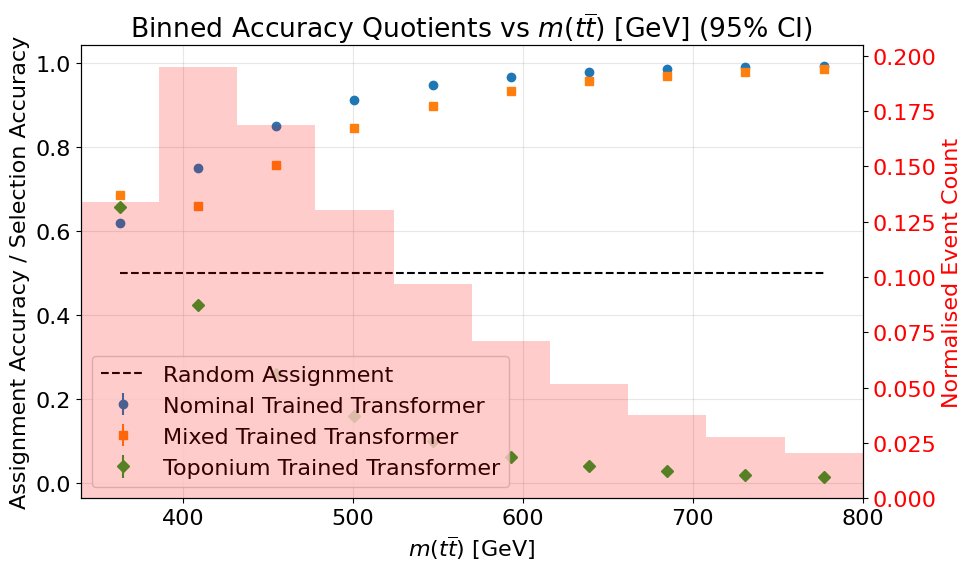

In [4]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_mass.pdf")

In [5]:
evaluator.save_accuracy_latex_table(n_bootstrap=100, confidence=0.95, save_dir=PLOTS_DIR)

LaTeX table saved to plots/compare_mixed_model/reconstruction_accuracies_table.tex



Computing binned $c_{\text{hel}}$ Resolution for truth_ttbar_mass...


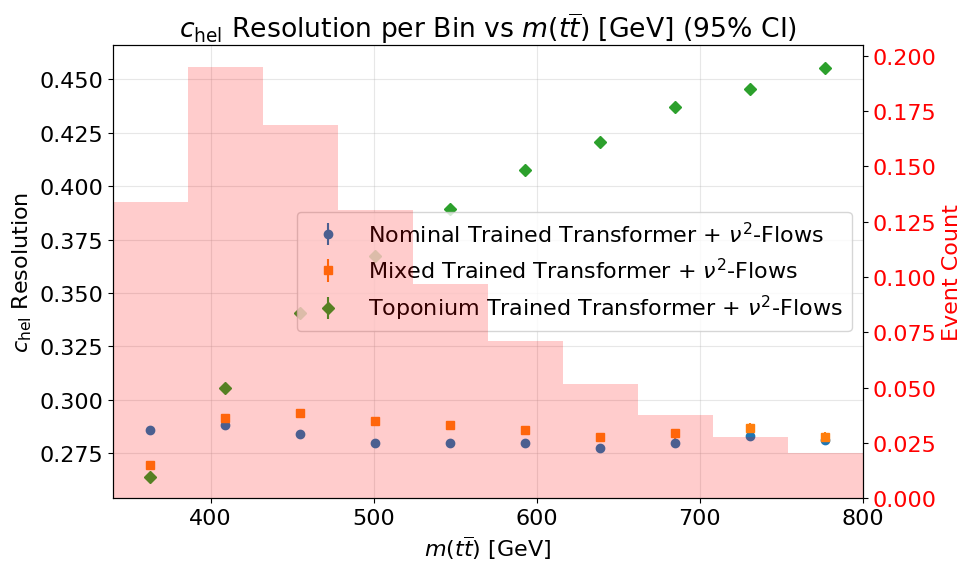

In [6]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")


Computing binned $c_{\text{han}}$ Resolution for truth_ttbar_mass...


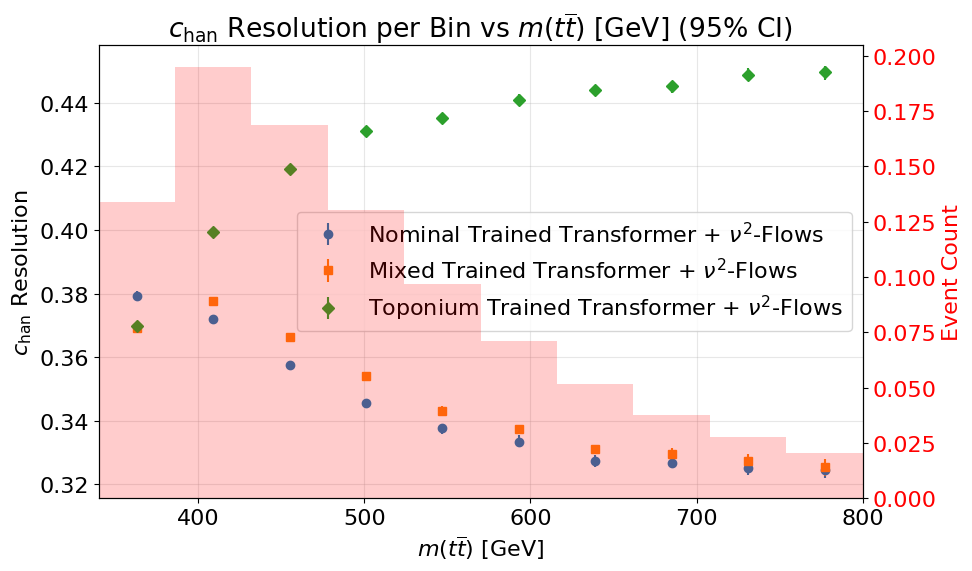

In [7]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")


Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...


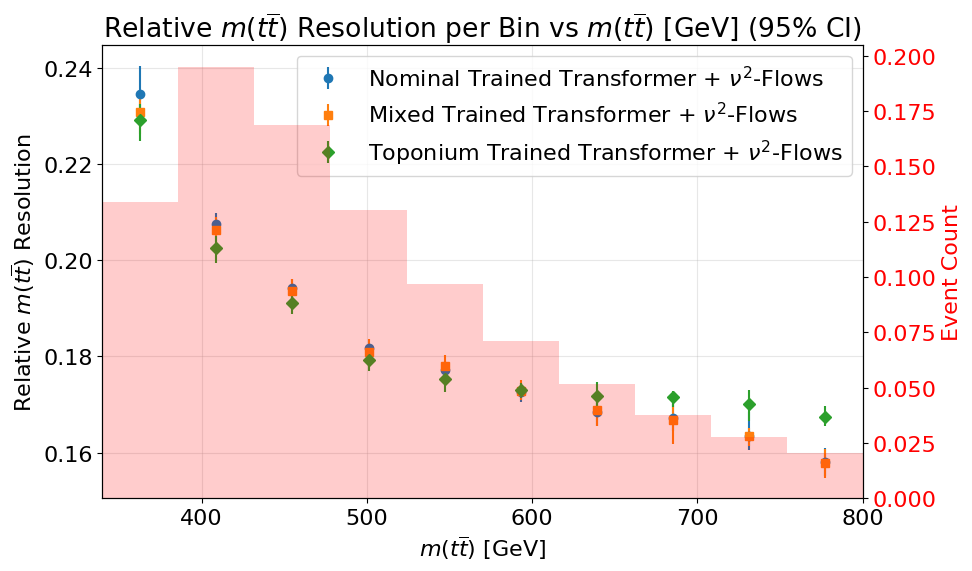

In [8]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")

## Accuracy Plots


Computing bootstrap confidence intervals...
Nominal Trained Transformer: 0.8178 [0.8175, 0.8182]
Mixed Trained Transformer: 0.7746 [0.7743, 0.7750]
Toponium Trained Transformer: 0.2347 [0.2344, 0.2349]


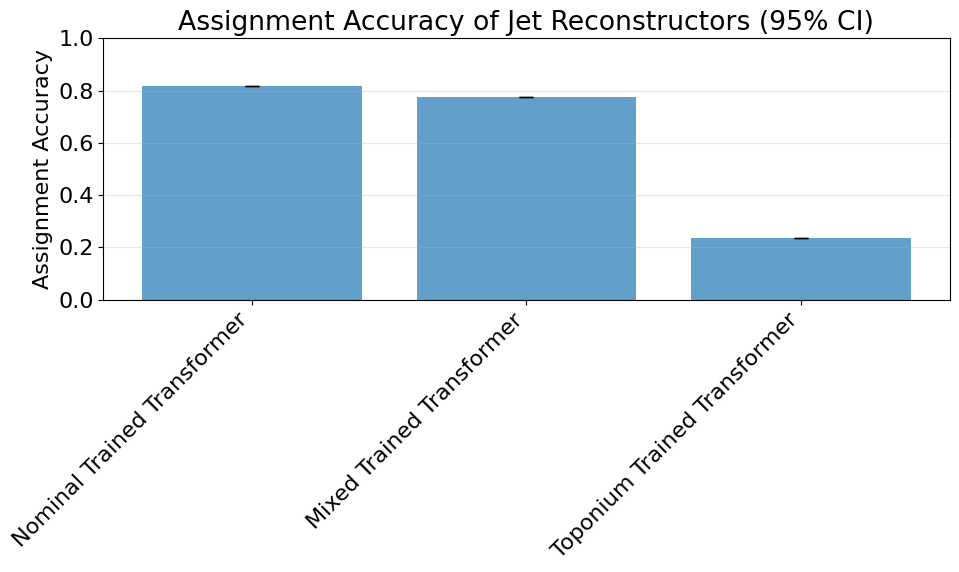

In [9]:
fig, ax = evaluator.plot_all_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
Nominal Trained Transformer: 0.9582 [0.9579, 0.9584]
Mixed Trained Transformer: 0.9552 [0.9549, 0.9555]
Toponium Trained Transformer: 0.8588 [0.8585, 0.8591]


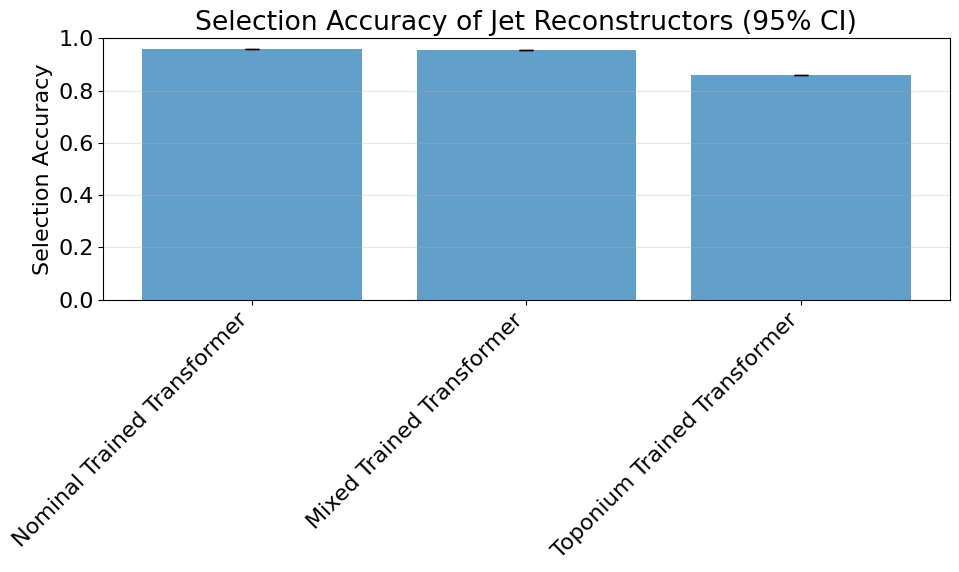

In [10]:
fig, ax = evaluator.plot_all_selection_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned accuracy for N_jets...


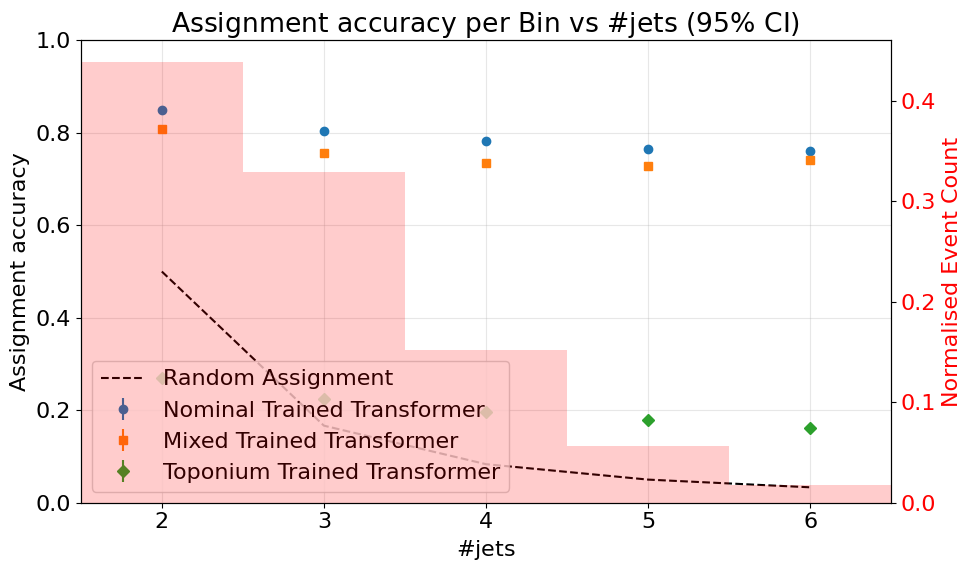

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy quotients for N_jets...


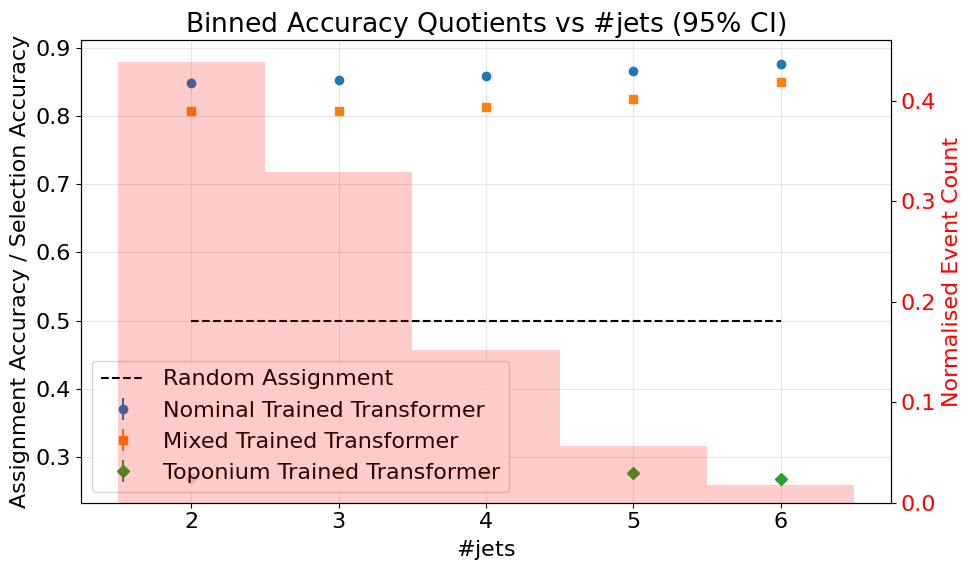

In [12]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


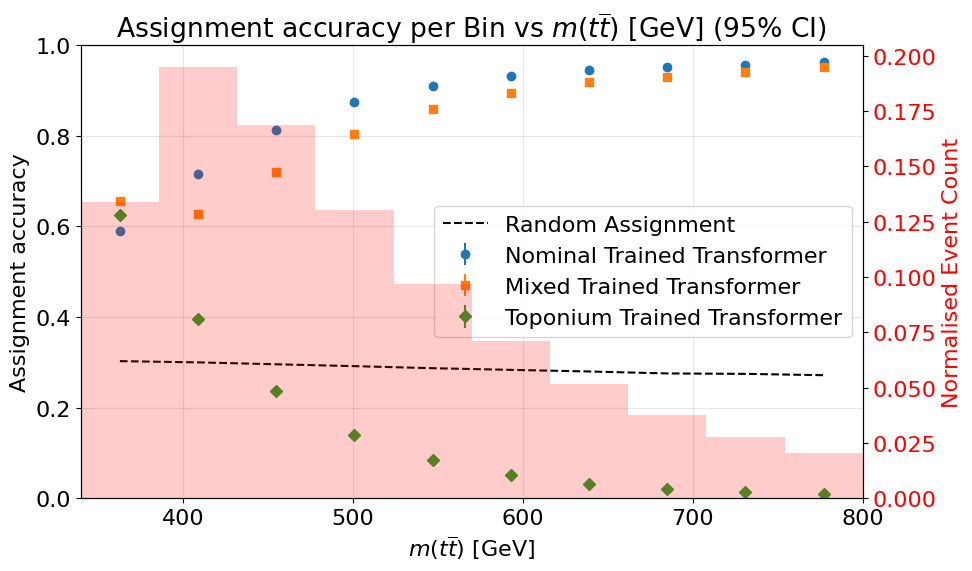

In [13]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


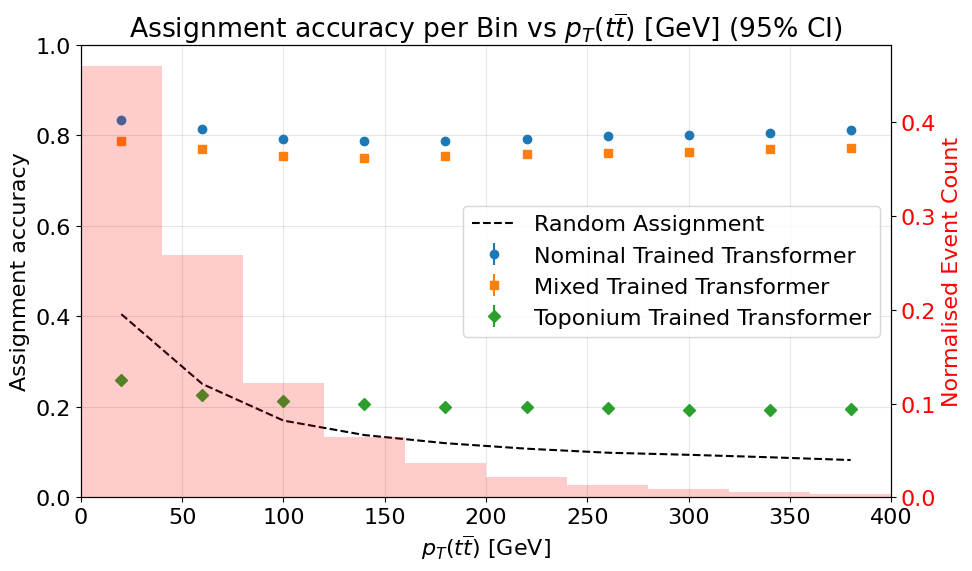

In [14]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy quotients for truth_ttbar_pt...


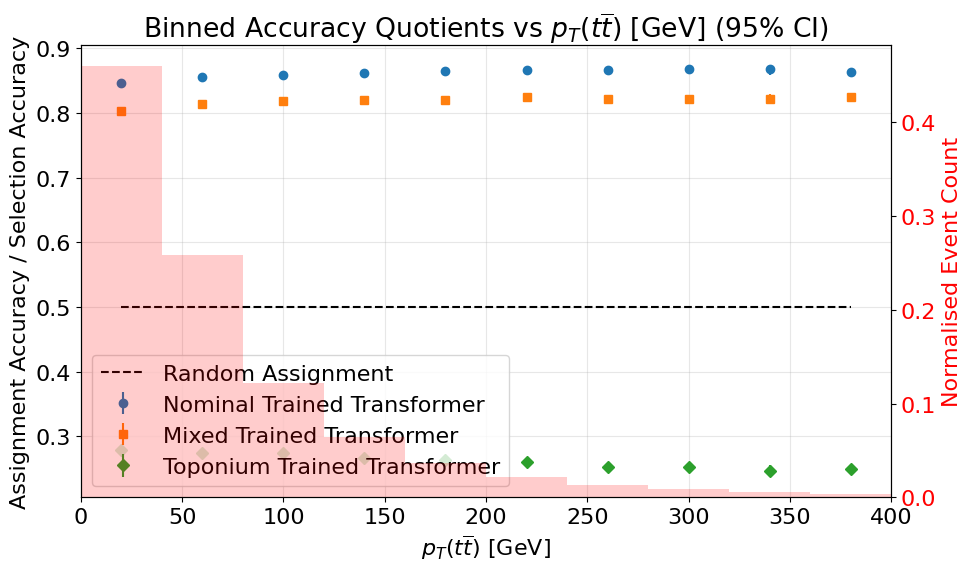

In [15]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_pT.pdf")


Computing binned accuracy for dR_l1l2...


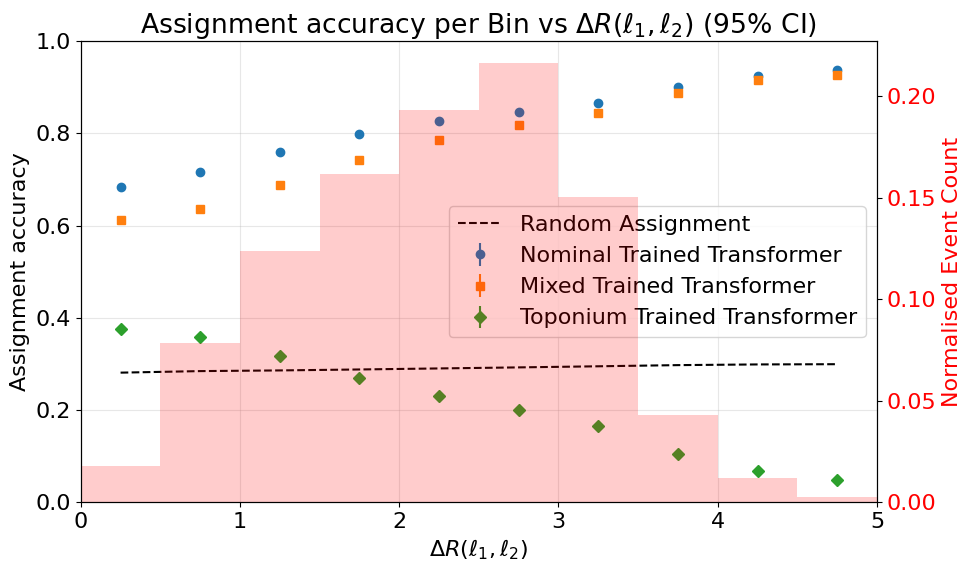

In [16]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")


Computing binned accuracy for truth_ttbar_mass...


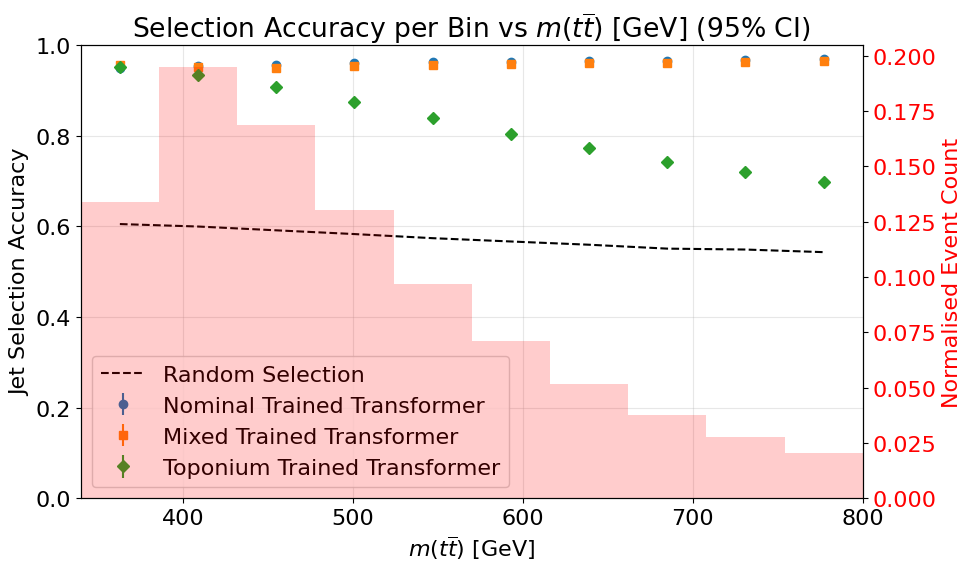

In [17]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")


Computing binned accuracy for N_jets...


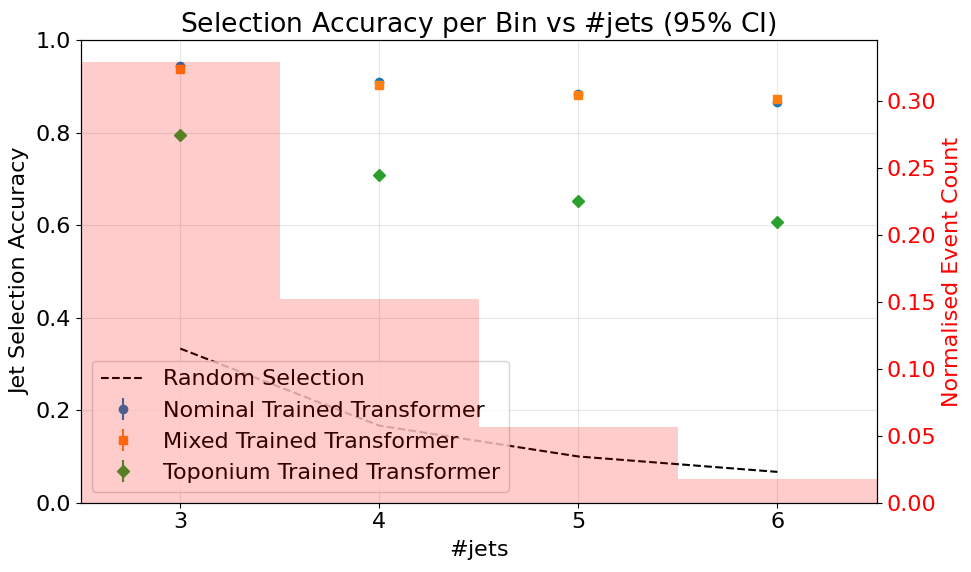

In [18]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(3, data_config.max_jets + 1),
    bins=data_config.max_jets - 2,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(3, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(3, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_N_jets.pdf")

## Distribution Plots

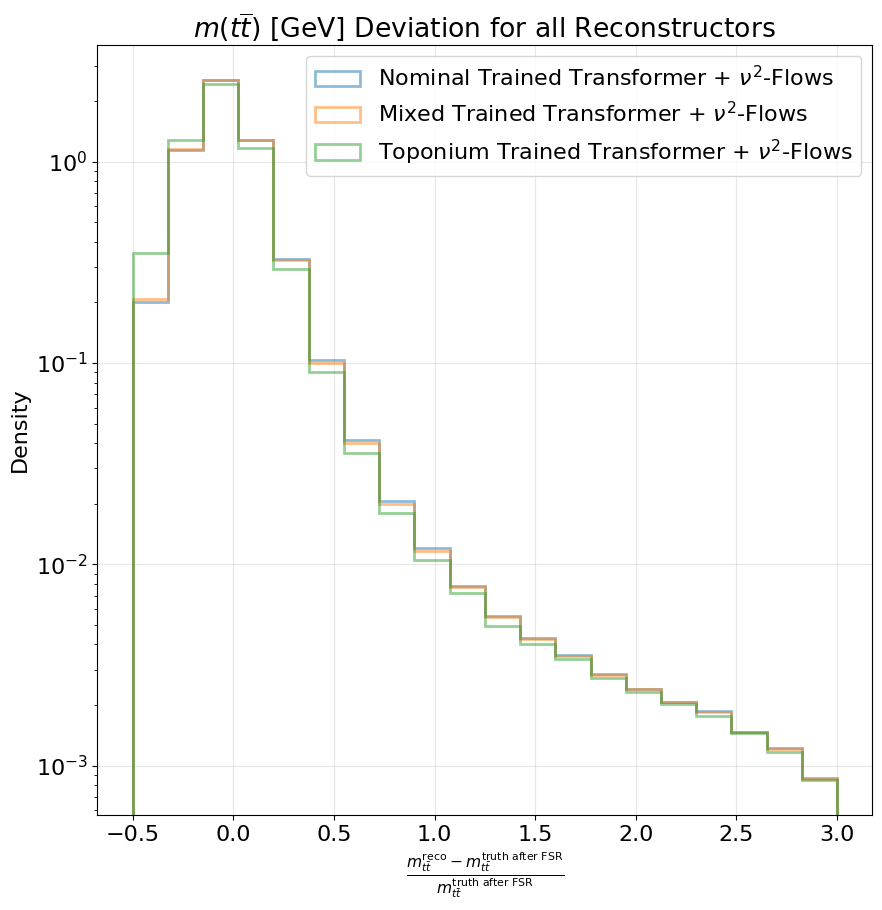

In [19]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins=20, xlims=(-0.5, 3))
ax.set_yscale("log")
ax.set_xlabel(
    r"$\frac{m_{t\bar{t}}^{\text{reco}}-m_{t\bar{t}}^{\text{truth after FSR}}}{m_{t\bar{t}}^{\text{truth after FSR}}}$"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.pdf", bbox_inches="tight")

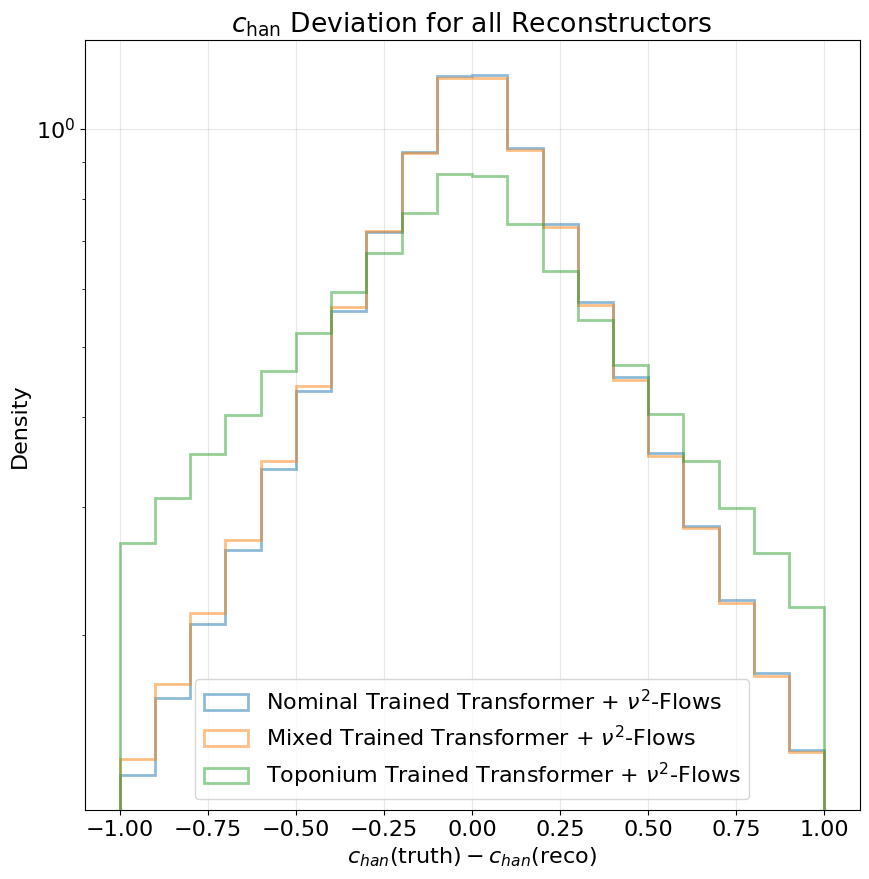

In [20]:
fig, ax = evaluator.plot_c_han_deviation_distribution(bins=20, xlims=(-1, 1))
ax.set_yscale("log")
ax.set_xlabel(
    r"$c_{han}(\text{truth}) - c_{han}(\text{reco}) $"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_c_han_deviation_distribution.pdf", bbox_inches="tight")

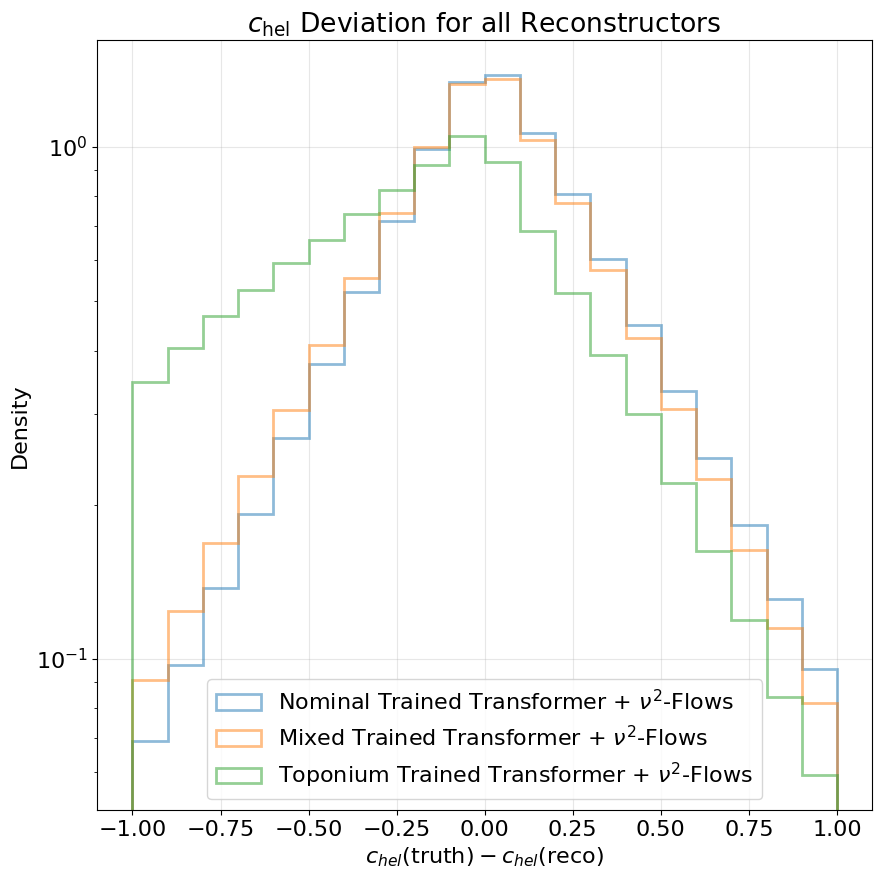

In [21]:
fig, ax = evaluator.plot_c_hel_deviation_distribution(bins=20, xlims=(-1, 1))
ax.set_yscale("log")
ax.set_xlabel(
    r"$c_{hel}(\text{truth}) - c_{hel}(\text{reco})$"
)
fig.savefig(f"{PLOTS_DIR}/ttbar_c_hel_deviation_distribution.pdf", bbox_inches="tight")

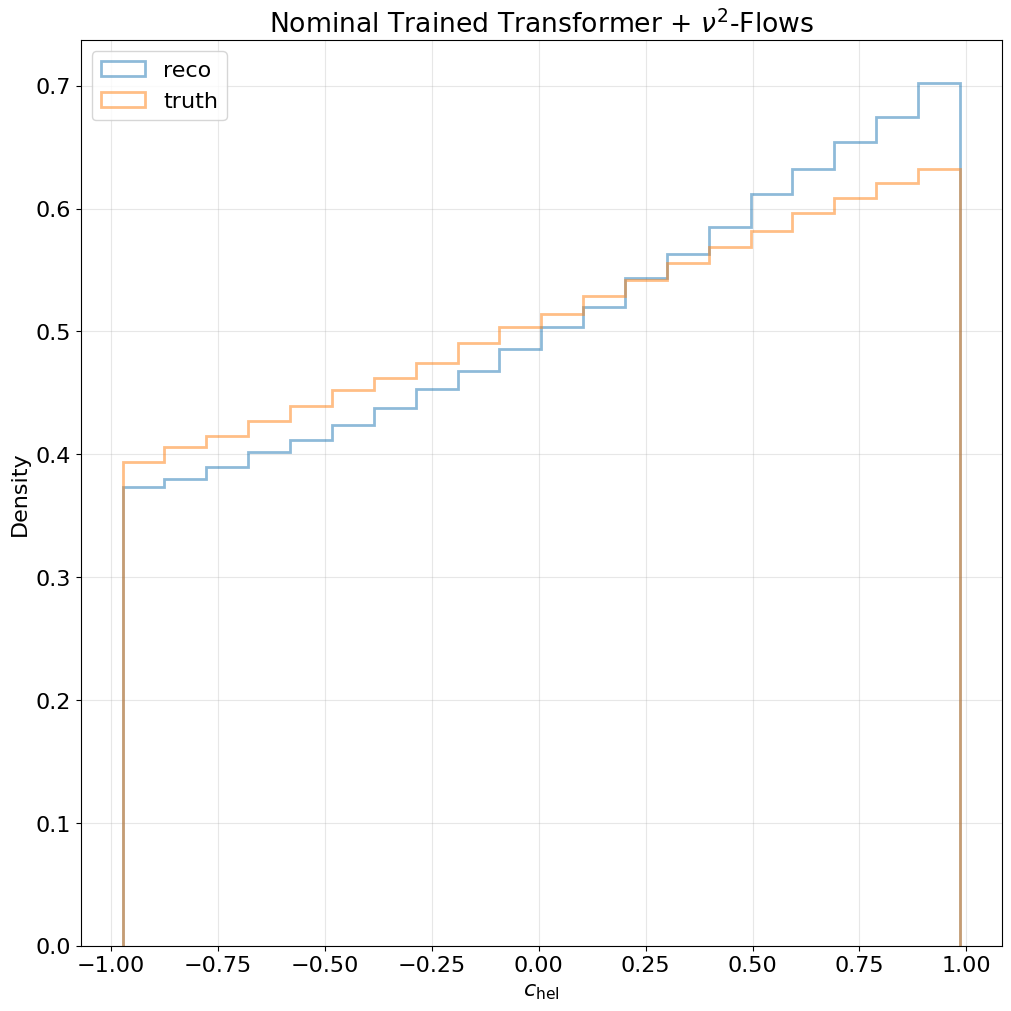

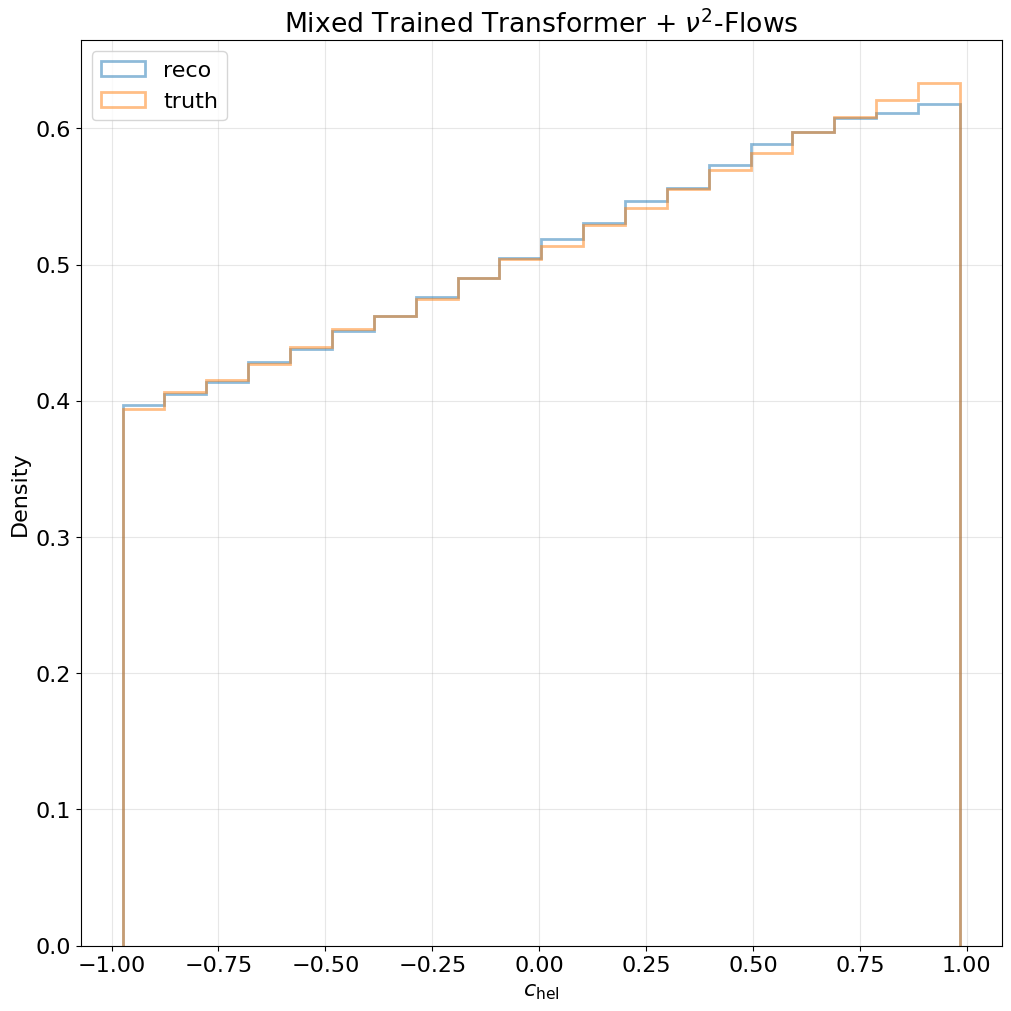

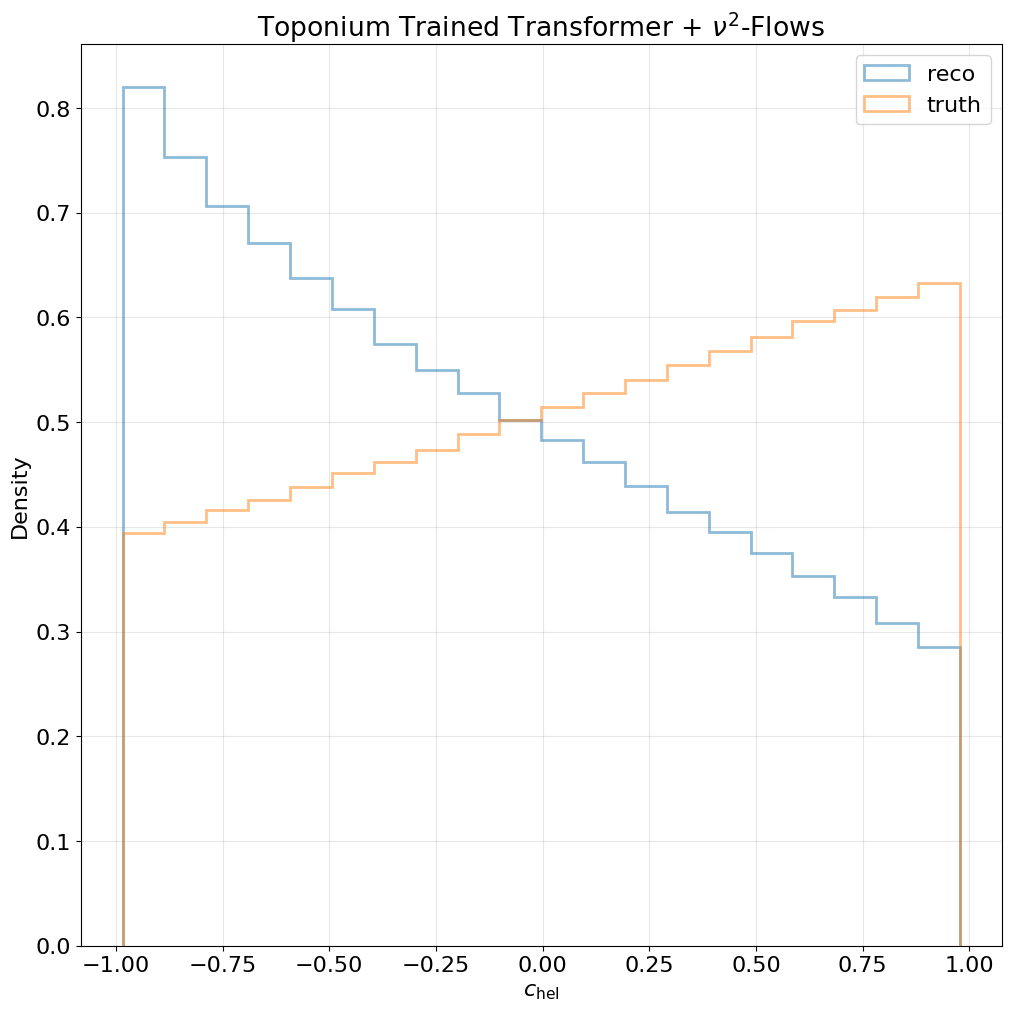

In [22]:
fig, axes = evaluator.plot_c_hel_distributions(bins=20, save_individual_plots=True)
for index, figure in enumerate(fig):
    figure.savefig(f"{PLOTS_DIR}/c_hel_distributions_{index}.pdf", bbox_inches="tight")

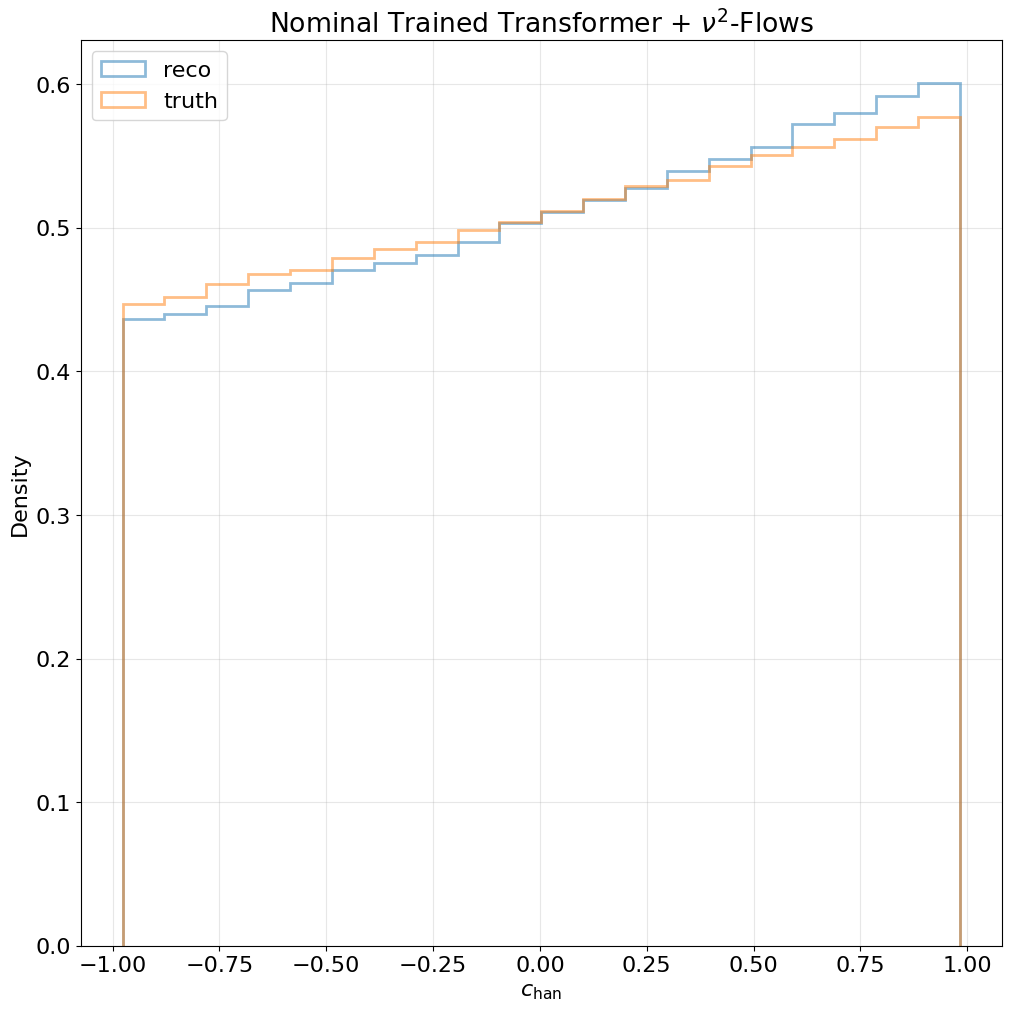

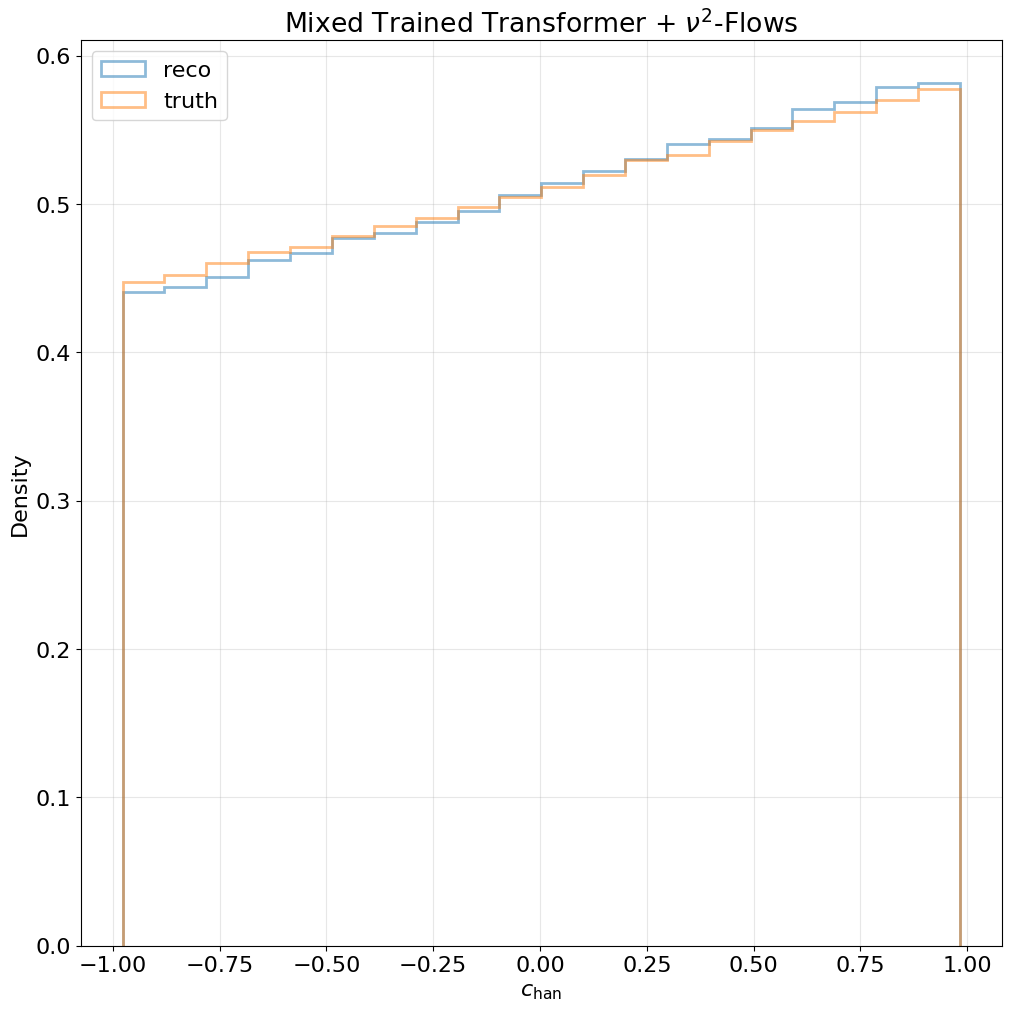

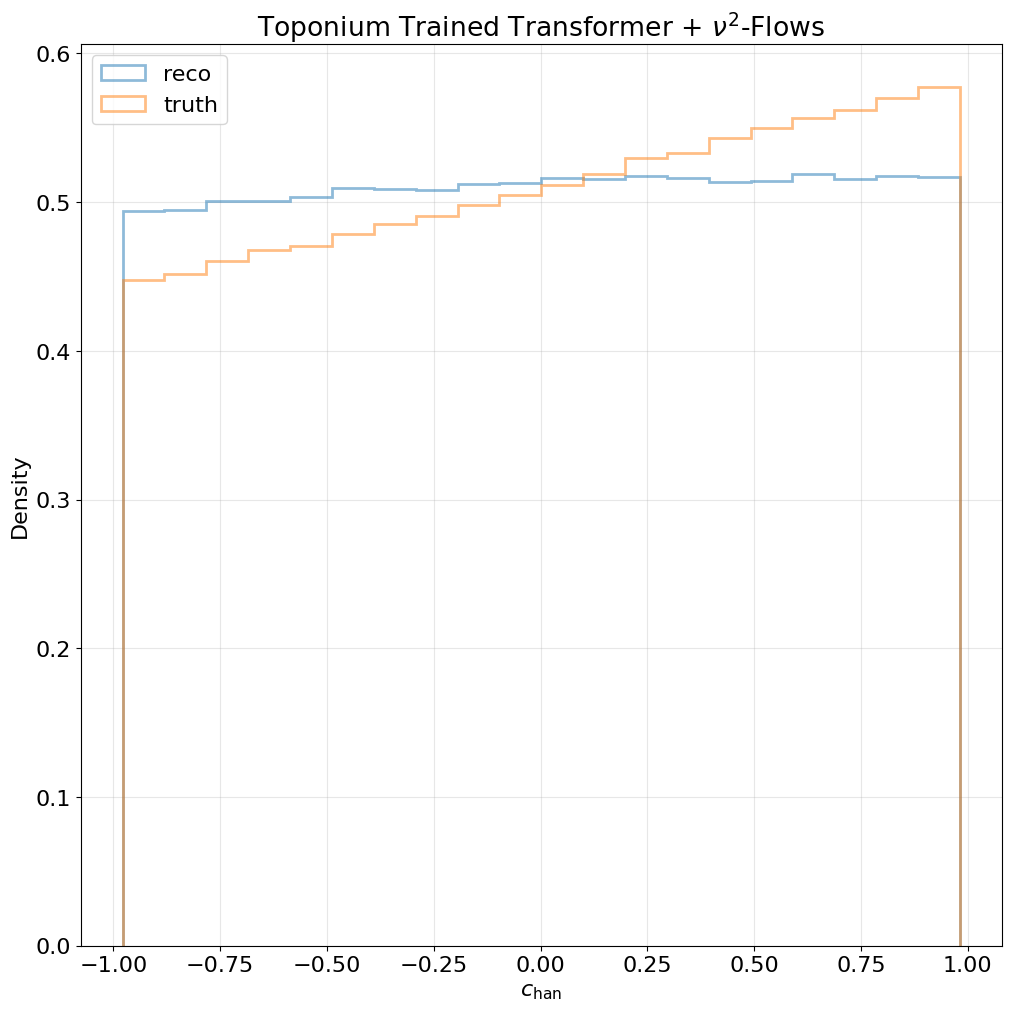

In [23]:
fig, axes = evaluator.plot_c_han_distributions(bins=20, save_individual_plots=True)
for index, figure in enumerate(fig):
    figure.savefig(f"{PLOTS_DIR}/c_han_distributions_{index}.pdf", bbox_inches="tight")

## Resolution Plots

## Mass Resolution and Deviation Plots


Computing binned Relative $m(t)$ Resolution for truth_ttbar_mass...


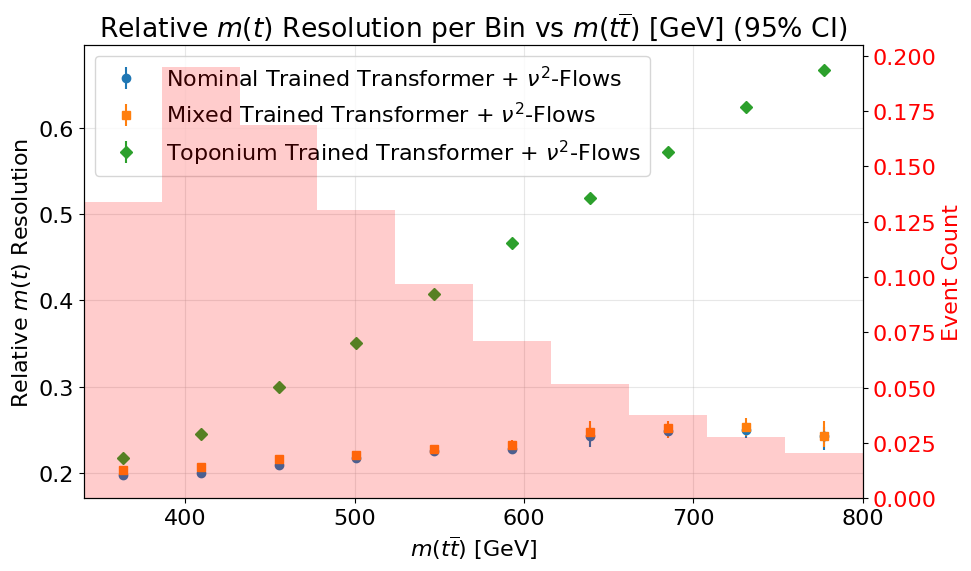

In [24]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned Mean Relative $m(t)$ Deviation for truth_ttbar_mass...


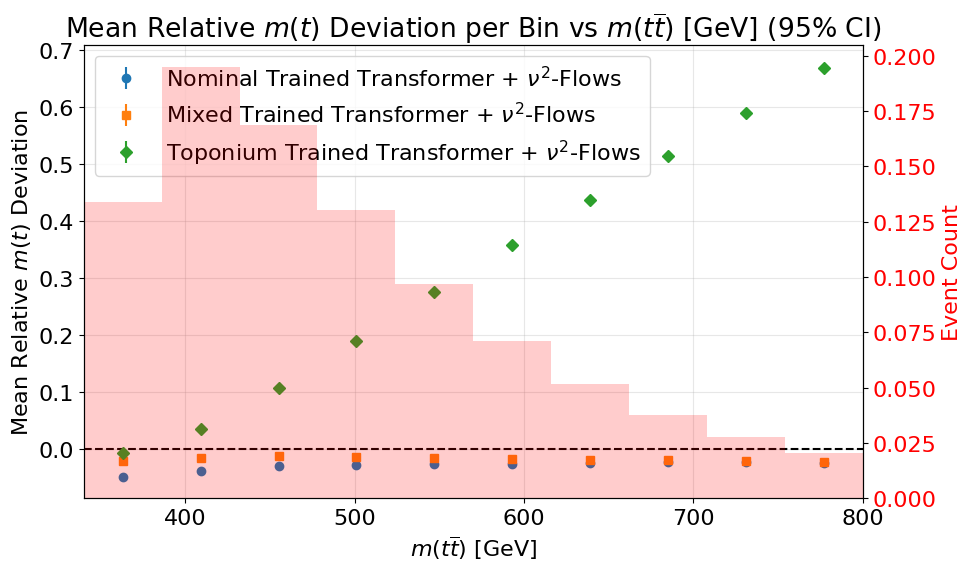

In [25]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
    bins=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")


Computing binned Mean Relative $m(t\overline{t})$ Deviation for truth_ttbar_mass...


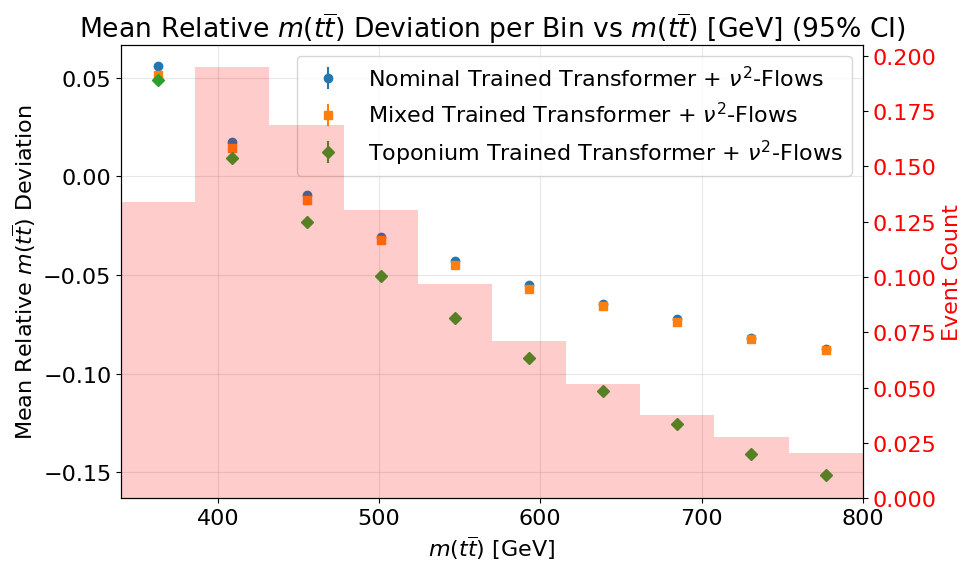

In [26]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")


Computing binned Mean $c_{\text{hel}}$ Deviation for truth_ttbar_mass...


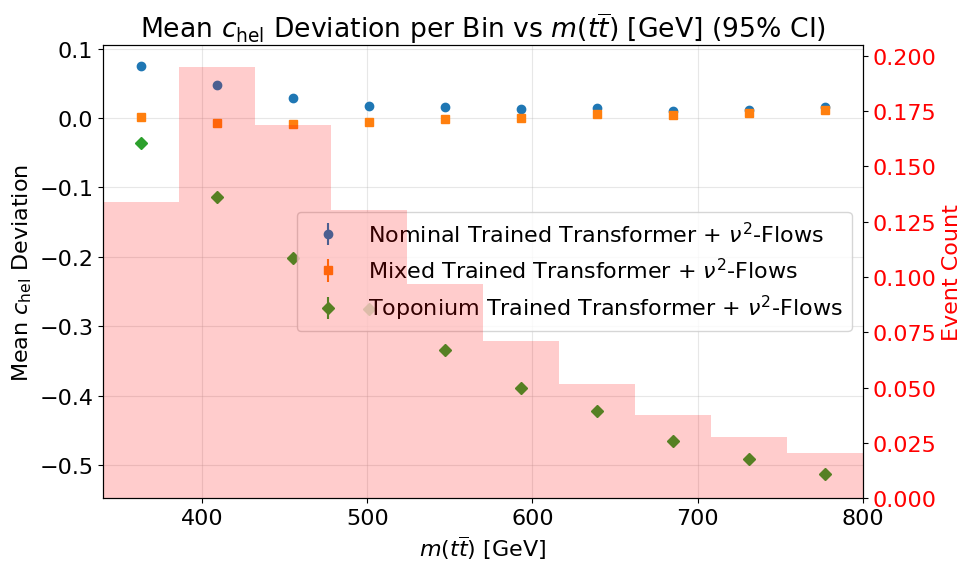

In [27]:
fig, ax = evaluator.plot_binned_c_hel_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_deviation_comparison.pdf")


Computing binned Mean $c_{\text{han}}$ Deviation for truth_ttbar_mass...


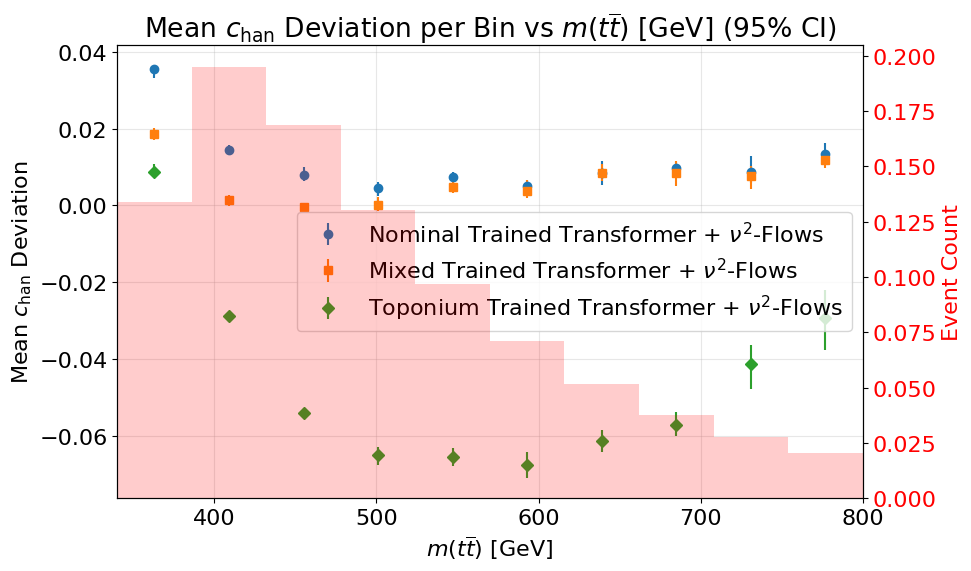

In [28]:
fig, ax = evaluator.plot_binned_c_han_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_deviation_comparison.pdf")

## Confusion Matrices and Complementarity


Computing binned accuracy for truth_initial_parton_num_gluons...


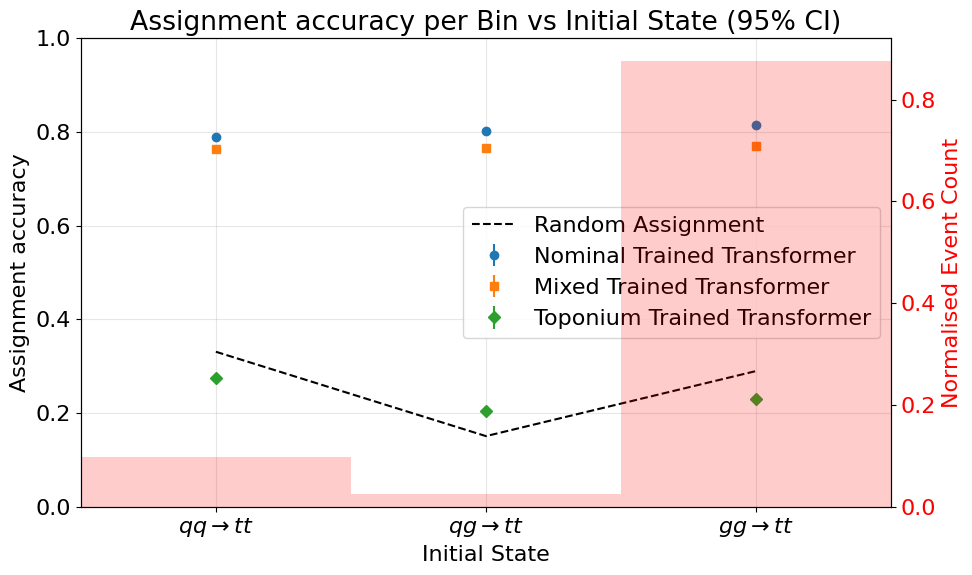

In [29]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")

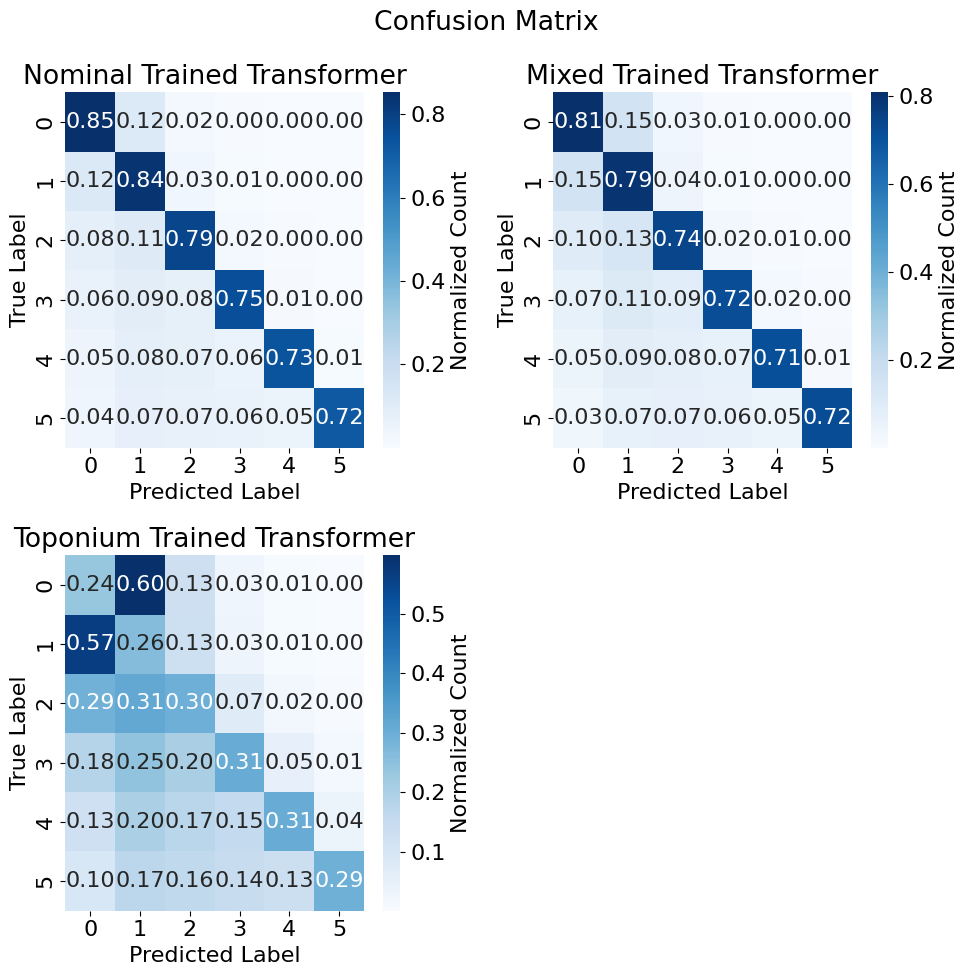

In [30]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

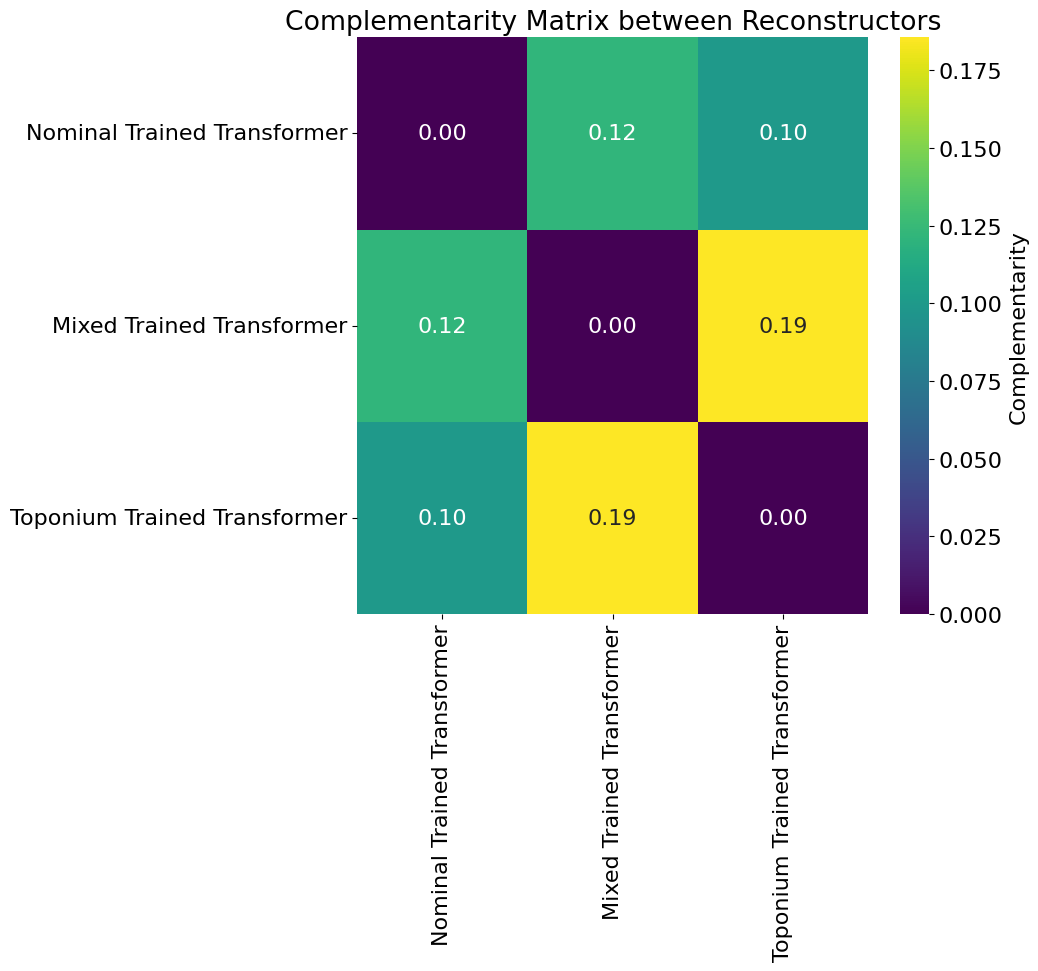

In [31]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(10.5, 10))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")